# RAG - Retrieval-Augmented Generation

В этом ноутбуке мы:

1. Повторим теорию RAG (что делает ретривер, что делает генератор и зачем они друг другу нужны).

2. Подготовим окружение (установим нужные версии `transformers`, `langchain`, `chromadb`, `bitsandbytes`).Всё тестируем на обычном ноутбуке.

3. Соберём рабочий пайплайн: **DeepSeek-R1-Distill-Llama-8B → LangChain → ChromaDB → RAG‑цепочка**.

4. Натравим RAG на небольшой англоязычный корпус (мини‑выборка из Википедии) и научимся задавать вопросы по‑английски.

5. Оценим качество простейшей метрикой (accuracy@k) и обсудим, куда расти дальше.


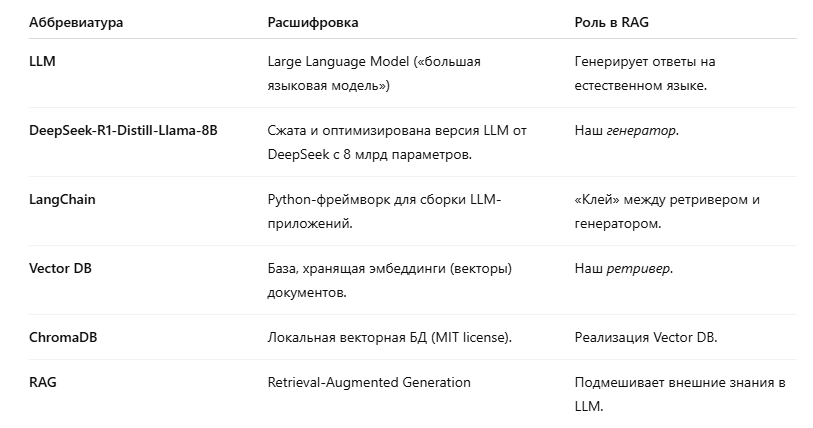

### Что такое Retrieval‑Augmented Generation?

LLM умеют отвечать на вопросы, *если* знали факты при обучении.
Когда вопрос выходит за рамки их памяти, модель начинает галлюцинировать.
**RAG‑архитектура** решает проблему так:

1. **Retriever (извлекатель):**

   * Делает эмбеддинги из текстов (например, с помощью `sentence-transformers`).
   * Индексирует их во векторной базе (`ChromaDB`).
   * По запросу находит самые релевантные отрывки.

2. **Generator (генератор):**

   * Использует LLM (в нашем случае — DeepSeek) для генерации ответа.
   * На вход подаются запрос + найденные документы.

3. **Langchain orchestration:**

   * Автоматизирует связку извлекателя и генератора

Таким образом мы можем
*а)* держать данные локально,
*б)* обновлять знания без дообучения модели.


### pips

In [ ]:
!pip install -q --upgrade pip
!pip uninstall -y fastai torch torchvision torchaudio gcsfs fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.6 MB/s eta 0:00:00
Found existing installation: fastai 2.7.19
Uninstalling fastai-2.7.19:
  Successfully uninstalled fastai-2.7.19
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: gcsfs 2025.3.2
Uninstalling gcsfs-2025.3.2:
  Successfully uninstalled gcsfs-2025.3.2
Found existing installation: fsspec 2025.3.2
Uninstalling fsspec-2025.3.2:
  Successfully uninstalled fsspec-2025.3.2


In [ ]:
!pip install -q torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1 \
    --index-url https://download.pytorch.org/whl/cu118

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 113.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 124.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 59.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'lit' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lit'. Discussion can be found at https://github.com/pypa/pip/issues/6334
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [torchaudio]


In [ ]:
!pip install -q fsspec==2025.3.2 gcsfs==2025.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [gcsfs]


In [ ]:
!pip install -q \
    bitsandbytes==0.46.0 \
    transformers==4.52.4 \
    accelerate==1.8.1 \
    datasets==3.6.0 \
    sentence-transformers==4.1.0 \
    chromadb==1.0.13 \
    langchain==0.3.26 \
    langchain-community==0.3.26 \
    langchain-huggingface \
    tqdm==4.67.1

### BitsAndBytesConfig

**Что вообще по железу в колабе?**

GPU

| Название | Архитектура  | VRAM (примерно) | Особенности                       |
| -------- | ------------ | --------------- | --------------------------------- |
| **A100** | Ampere       | 40–80 GB        | Самый мощный, обычно в Colab Pro+ |
| **L4**   | Ada Lovelace | 24 GB           | Новый, ускоренный inference       |
| **T4**   | Turing       | 16 GB           | Часто доступен в бесплатном Colab |

TPU

| TPU       | Версия | Количество ядер | Примечание                        |
| --------- | ------ | --------------- | --------------------------------- |
| TPU v2-8  | v2     | 8               | Старый, но всё ещё рабочий        |
| TPU v5e-1 | v5e    | 1               | Новый экономичный вариант         |
| TPU v6e-1 | v6e    | 1               | Один из новейших TPU, часто в Pro |

TPU (Tensor Processing Unit) — это специализированный чип (процессор), разработанный компанией Google для ускорения вычислений в задачах машинного обучения, особенно — для тензорных операций, характерных для нейросетей. Грубо говоря, ML-ускоритель - канает для TensorFlow и JAX.

In [ ]:
!nvidia-smi

Fri Jun 20 12:55:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Тогда вопрос, а если моделька слишком большая или мы сильно ограничены в ресурсах? Используем `BitsAndBytesConfig`!

Когда пойдет его использовать?

* Хочешь запустить **большую LLM на ограниченном железе** (например, RTX 3060 с 6–8 GB VRAM).
* Выполняешь **инференс** (а не обучение).
* Используешь **RAG, chat-ботов или QA-сценарии**, где важна скорость и "достаточная" точность.

`BitsAndBytesConfig` — это специальный класс из библиотеки `transformers`от Hugging Face, который используется для настройки квантования модели при загрузке, особенно в связке с библиотекой `bitsandbytes`. Он позволяет уменьшить объём памяти, занимаемый моделью, за счёт представления весов не в стандартном 16- или 32-битном формате, а в 4- или 8-битном формате.

| Параметр                                | Описание                                                                                                                                |
| --------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------- |
| `load_in_4bit=True`                     | Загружаем веса модели в 4-битном формате (сильно уменьшает потребление памяти).                                                         |
| `bnb_4bit_quant_type="nf4"`             | Тип квантования. `nf4` — лучше сохраняет точность (рекомендуется).                                                                      |
| `bnb_4bit_use_double_quant=True`        | Включает двойное квантование — дополнительно уменьшает размер модели за счёт квантования параметров квантования (мета-квантование). |
| `bnb_4bit_compute_dtype=torch.bfloat16` | Указывает, в каком типе данных (dtype) производить вычисления. `bfloat16` быстрее и точнее, чем float16 на большинстве GPU.             |

### import




In [ ]:
from torch import cuda, bfloat16
import torch, transformers
import torchvision
from transformers import AutoTokenizer, BitsAndBytesConfig, pipeline

torchvision.disable_beta_transforms_warning()
DEVICE = f"cuda:{cuda.current_device()}" if cuda.is_available() else "cpu"

In [ ]:
import sys
print(transformers.__version__, sys.executable)

4.52.4 /usr/bin/python3


In [ ]:
import bitsandbytes as bnb, importlib, os
print(bnb.__version__)
!ldconfig -p | grep cusparse | head -n 3

0.46.0
	libcusparse.so.12 (libc6,x86-64) => /usr/local/cuda/targets/x86_64-linux/lib/libcusparse.so.12
	libcusparse.so (libc6,x86-64) => /usr/local/cuda/targets/x86_64-linux/lib/libcusparse.so


### LLM

In [ ]:
MODEL_ID = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# MODEL_ID = "deepseek-ai/deepseek-coder-7b-instruct"

# Квантуем в 4 бита, чтобы поместилось в VRAM 6–8 ГБ
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                          # включить 4-битное квантование
    bnb_4bit_quant_type="nf4",                  # тип квантования: "nf4" (Normalized Float 4) или "fp4"
    bnb_4bit_use_double_quant=True,             # включить двойное квантование (дополнительная компрессия)
    bnb_4bit_compute_dtype=torch.float16        # тип данных для вычислений (например, bfloat16 (недоступен на T4), float16)
)

print("Загружаем модель …")
model = transformers.AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    # trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

llm_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16, # на всякий случай лучше передать
    device_map="auto",
)

Загружаем модель …


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-000002.safetensors:   0%|          | 0.00/7.39G [00:00<?, ?B/s]

model-00001-of-000002.safetensors:   0%|          | 0.00/8.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Device set to use cuda:0


Мини-инференс

In [ ]:
def ask_DeepSeek(prompt: str):
    resp = llm_pipeline(
        prompt,
        max_length=200,
        # max_new_tokens=200,     # генерируем ≤ 200 новых токенов
        do_sample=True,
        truncation=True,
        top_k=20,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
    )[0]["generated_text"]
    print(resp)

ask_DeepSeek("Объясни, пожалуйста, что такое ‘State of the Union’. Ответь одним абзацем.")

Объясни, пожалуйста, что такое ‘State of the Union’. Ответь одним абзацем. Для ответа, я должен описать, что такое 'State of the Union' и, возможно, дать пример или примеры, если это необходимо.

**State of the Union**  
(State of the Union) – это официальный доклад, который предоставляет информацию о текущем состоянии США, включая общие тенденции, изменения в экономике, социальной сфере, политике и других важных аспектах. Этот доклад обычно направлен к Конгрессу и включает в себя мнение Президента о том, как страны нужно продолжать действовать, чтобы достичь своих целей. Примером может быть доклад, который подает Президент США каждую годовую сессию Конгресса, описывая текущее положение дел и свои рекомендации.

**State of the Union**  
(State of the Union) – это ежегодное обращение Президента США к Конгрессу,


### Данные

In [ ]:
from datasets import load_dataset
from langchain.docstore.document import Document

wiki_ds = load_dataset("rag-datasets/rag-mini-wikipedia", name="text-corpus", split="passages")

# Document
corpus_docs = [
    Document(page_content=rec["passage"], metadata={"id": rec["id"]})
    for rec in wiki_ds
]

print("Документов:", len(corpus_docs))
print(corpus_docs[0].page_content[:200], "…")

README.md:   0%|          | 0.00/719 [00:00<?, ?B/s]

part.0.parquet:   0%|          | 0.00/797k [00:00<?, ?B/s]

Generating passages split:   0%|          | 0/3200 [00:00<?, ? examples/s]

Документов: 3200
Uruguay (official full name in  ; pron.  , Eastern Republic of  Uruguay) is a country located in the southeastern part of South America.  It is home to 3.3 million people, of which 1.7 million live in …


In [ ]:
wiki_ds

Dataset({
    features: ['passage', 'id'],
    num_rows: 3200
})

### LangChain

<img src="https://miro.medium.com/v2/resize:fit:940/1*44fD_VXcqw2kDWublQLONw.jpeg" alt="LangChain vs LLM Stack" width="400">


[LangChain](https://github.com/langchain-ai/langchain) — это Python-фреймворк для создания **приложений на базе больших языковых моделей (LLM)**, таких как LLaMA, GPT, DeepSeek и другие. Он упрощает построение цепочек (`chains`), где LLM взаимодействует с внешними источниками знаний, выполняет пошаговые вычисления, вызывает инструменты и возвращает результат в едином пайплайне.

| Альтернатива                          | Особенности                                                             |
| ------------------------------------- | ----------------------------------------------------------------------- |
| **LlamaIndex**                        | Более прост в использовании для RAG, хорошая интеграция с векторными БД |
| **Haystack (deepset)**                | Акцент на продакшн-решения, поисковые пайплайны и поддержка OpenSearch  |
| **Semantic Kernel**                   | От Microsoft, хорошо стыкуется с .NET и Azure-LLM                       |
| **Transformers Agents** (HuggingFace) | Базовая альтернатива без полноценного workflow, но нативная             |


In [ ]:
from pathlib import Path

from langchain.document_loaders import TextLoader  # загружает текстовые файлы и превращает их в объекты Document для LangChain.
from langchain.text_splitter import RecursiveCharacterTextSplitter  # рекурсивно разбивает длинный текст на более мелкие фрагменты (chunks).
from langchain_huggingface import HuggingFaceEmbeddings  # оборачивает модели из HuggingFace для получения эмбеддингов текста.
from langchain.vectorstores import Chroma  # векторное хранилище Chroma: сохраняет и ищет эмбеддинги.

from langchain_huggingface import HuggingFacePipeline  # использует HuggingFace Transformers pipeline как LLM-модуль в LangChain.
from langchain.chains import RetrievalQA  # готовая цепочка «поиск + генерация ответа» (Retrieval-augmented QA).

In [ ]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=512, chunk_overlap=50
)

docs = splitter.split_documents(corpus_docs)
print("Чанков:", len(docs))

Чанков: 4430


Зачем рубить документы на чанки (короткие фрагменты)?

* **Лимит контекста модели**

  *Целиком длинный документ ( > 5 000 токенов) в контекст не влезет.*
  Разбив по 300-800 токенов, гарантируем, что каждый кусок поместится и ретривер сможет вернуть несколько штук.

* **Точность поиска (Recall)**

  *Огромный текст становится «одним большим вектором» — нужный абзац теряется.*
  Отдельный эмбеддинг на каждый абзац повышает шанс, что именно релевантный фрагмент попадёт в top-k.

* **Память и скорость индекса**

  *Вектор 4 000 токенов ≈ 12 KB; индекс из сотен таких векторов раздувается и тормозит.*
  Мелкие чанки -> меньше эмбеддингов -> компактная и быстрая база.

* **Понятные ссылки в ответах**

  *Трудно показать, какой именно фрагмент подтверждает вывод.*
  Когда хранится маленький кусок, его легко вернуть и процитировать как источник.

* **Смысловая целостность (overlap)**

  *Без перекрытия граница чанков режет мысли пополам.*
  Небольшой `chunk_overlap` (≈ 50 токенов) оставляет фразы целыми, и ретривер не пропускает факты «на стыке».


### Создание векторной базы

`Chroma` — это интерфейс к векторной базе данных ChromaDB, встроенный в LangChain. Он позволяет:

* сохранять текстовые документы как **векторные представления** (эмбеддинги),
* осуществлять **поиск по векторной близости** (косинусное сходство и др.),
* использовать найденные документы в Retrieval-Augmented Generation (RAG).

**Сильные стороны**

- Быстрая установка (одна команда `pip install chromadb`)
- Хорошо интегрирован с LangChain
- Поддерживает метаданные
- Поддерживает фильтрацию
- Возможность персистентности — база сохраняется между сессиями
- Полностью **open-source**

**Слабые стороны**

- Заточена под **локальное** использование (не масштабируется так, как Faiss или Weaviate)
- Ограниченные возможности по сравнению с **облачными** векторными хранилищами
- Нельзя легко развернуть распределённо
- Меньше функций по фильтрации и агрегированию

Альтернативы `Chroma` в LangChain

| База              | Особенности                                     |
| ----------------- | ----------------------------------------------- |
| **FAISS**         | Очень быстрый и простой, но без метаданных      |
| **Weaviate**      | Облачная/локальная, продвинутая фильтрация      |
| **Pinecone**      | SaaS, высокая масштабируемость                  |
| **Qdrant**        | Open-source, фильтрация, кластеризация          |
| **Milvus**        | Мощная и масштабируемая, но сложнее в настройке |
| **Elasticsearch** | Поддержка вектора + ключевых слов               |


In [ ]:
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    model_kwargs={"device": "cuda"},
)

vectordb = Chroma.from_documents(
    documents=docs,               # либо corpus_docs, если без сплиттера
    embedding=embeddings,
    persist_directory="chroma_ragmini"  # директория для хранения векторной базы
)
vectordb.persist()

## Сборка цепочки RetrievalQA

In [ ]:
from transformers import GenerationConfig

gen_cfg = GenerationConfig.from_pretrained(MODEL_ID)
gen_cfg.max_length     = 2048     # допустим любой контекст до 2048 токенов
gen_cfg.max_new_tokens = 128      # ограничиваем длину генерируемого ответа
# gen_cfg.do_sample = True
# gen_cfg.temperature = 0.0
# gen_cfg.top_p = 0.9

model.generation_config = gen_cfg   # привязываем к модели

In [ ]:
from langchain import PromptTemplate

llm = HuggingFacePipeline(
    pipeline=llm_pipeline,          # тот, что мы собрали для DeepSeek
    model_kwargs={
        "max_new_tokens": 128,      # генерируем 128 новых токенов
        "temperature": 0.1,         # опционально
        "do_sample": False          # чтобы ответ был детерминирован
    }
)

retriever = vectordb.as_retriever()

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=False,
)

In [ ]:
question = "Was Abraham Lincoln the sixteenth President of the United States?"

answer_str = qa_chain.run(question)
print("Ответ:", answer_str)

Ответ: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Abraham Lincoln (February 12, 1809 â April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, "[I]n his short autobiography written for the 1860 presidential campaign, Lincoln would describe his protest in the Illinois legislature as one that 'briefly defined his position on the slavery question, and so far as it goes, it was then the same that it is now." This was in

Abraham Lincoln (February 12, 1809 â April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, "[I]n his short autobiography written for the 1860 presidential campaign, Lincoln would

Мы видим, что сначала модель выводит статьи, затем идет ризонинг, а ответ мы получаем после маркера `</think>`. Мы можем вручную обрезать лишний текст в инфренсе, если он нам не нужен.

In [ ]:
raw = qa_chain.run(question)

marker = "</think>"

if marker in raw:
    final_answer = raw.split(marker, 1)[1].strip()

print(final_answer)

Yes, Abraham Lincoln was the sixteenth President of the United States. He served from March 4, 1861, until his assassination on April 15, 1865.


In [ ]:
question = "Did Lincoln sign the National Banking Act of 1863?"

answer_str = qa_chain.run(question)
print("Ответ:",  answer_str.split(marker, 1)[1].strip())

Ответ: Yes, Lincoln signed the National Banking Act of 1863.


Если нам кажется, что четыре статьи это избыточно - то давайте ограничим модель только одной. Тогда мы будем уверены, что она успеет закончить ризонинг до выхода за ограниченное чисто токенов.

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectordb.as_retriever(search_kwargs={"k": 1}), # здесь мы подаем ограничение
    return_source_documents=True,
)

# попробуем другую функцию - она возвращает и использованные документы
response = qa_chain.invoke("Did Lincoln's mother die of pneumonia?")
print("Ответ:", response["result"].split(marker, 1)[1].strip())
print("\nSource documents:")
for doc in response["source_documents"]:
    print(doc.page_content[:80], "…")

Ответ: No, Lincoln's mother did not die of pneumonia. She died of milk sickness, also known as puerperal infection, a bacterial infection that occurs after childbirth, often due to unsanitary conditions.

Source documents:
thirty-four years old, died of milk sickness. Soon afterwards, his father remarr …


Что здесь происходит:

1. **Запрос** (`"Кто такой Абрахам Линкольн?"`) преобразуется в эмбеддинг с помощью той же модели (`sentence-transformers/all-mpnet-base-v2`).
2. **Chroma** ищет в базе документы, у которых вектор максимально близок (по косинусному расстоянию) к вектору запроса.
3. **Возвращаются `k` ближайших документов** (по умолчанию `k=4`, но можно указать своё значение).
4. Возвращаемые объекты — это список `Document`, где:

   ```python
   results[0].page_content  # Текст документа
   results[0].metadata      # Метаданные (если они были добавлены)
   ```


### Валидация

In [ ]:
import json, tqdm

# функция для удаления всего до и включая маркер </think>
def strip_cot(raw: str, marker: str = "</think>") -> str:
    parts = raw.split(marker, 1)
    # если не влез COT в токены, выводим ответ как есть
    return parts[1].strip() if len(parts) == 2 else raw.strip()

testset = load_dataset("rag-datasets/rag-mini-wikipedia", "question-answer")["test"]

total, correct = 0, 0

print("Проверка 10 примеров:\n")
for sample in tqdm.tqdm(testset.select(range(4, 14))):
    q, gold = sample["question"], sample["answer"]

    result_dict = qa_chain.invoke(q)
    raw = result_dict["result"]
    # обрезаем COT
    pred = strip_cot(raw)

    print(f"\nВопрос: {q}")
    print(f"Ожидаемые ответы: {gold}")
    print(f"Ответ модели: {pred}")

    if any(g.lower() in pred for g in gold.lower()):
        correct += 1
    total += 1

print(f"\nAccuracy@10: {correct/total:.2%}")

Проверка 10 примеров:



 10%|█         | 1/10 [00:13<01:59, 13.33s/it]


Вопрос: When did Lincoln begin his political career?
Ожидаемые ответы: 1832
Ответ модели: Lincoln began his political career in 1832.

Answer: 1832


 20%|██        | 2/10 [00:26<01:45, 13.18s/it]


Вопрос: What did The Legal Tender Act of 1862 establish?
Ожидаемые ответы: the United States Note, the first paper currency in United States history
Ответ модели: The Legal Tender Act of 1862 established the United States Note, the first paper currency in U.S. history. This act was enacted to boost the money supply, which was crucial for funding the Civil War efforts.


 30%|███       | 3/10 [00:28<00:55,  7.99s/it]


Вопрос: Who suggested Lincoln grow a beard?
Ожидаемые ответы: 11-year-old Grace Bedell
Ответ модели: Grace Bedell suggested Lincoln grow a beard.


 40%|████      | 4/10 [00:45<01:09, 11.59s/it]


Вопрос: When did the Gettysburg address argue that America was born?
Ожидаемые ответы: 1776
Ответ модели: The Gettysburg Address argues that the American nation was born in 1776, redefining its founding to the Declaration of Independence rather than the Constitutional Convention of 1789.


 50%|█████     | 5/10 [01:05<01:13, 14.71s/it]


Вопрос: Did Lincoln beat John C. Breckinridge in the 1860 election?
Ожидаемые ответы: yes
Ответ модели: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

On November 6, 1860, Lincoln was elected as the 16th President of the United States, beating Democrat Stephen A. Douglas, John C. Breckinridge of the Southern Democrats, and John Bell of the new Constitutional Union Party. He was the first Republican president, winning entirely on the strength of his support in the North: he was not even on the ballot in nine states in the South, and won only 2 of 996 counties in the other Southern states. Lincoln gained 1,865,908 votes (39.9% of the total), for 180

Question: Did Lincoln beat John C. Breckinridge in the 1860 election?
Helpful Answer: Yes, he did. Lincoln won the popular vote and carried the electoral votes, despite losing many counties in the South.
End of the passage.



 60%|██████    | 6/10 [01:25<01:06, 16.57s/it]


Вопрос: Was Abraham Lincoln the first President of the United States?
Ожидаемые ответы: No
Ответ модели: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Abraham Lincoln (February 12, 1809 â April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, "[I]n his short autobiography written for the 1860 presidential campaign, Lincoln would describe his protest in the Illinois legislature as one that 'briefly defined his position on the slavery question, and so far as it goes, it was then the same that it is now." This was in

Question: Was Abraham Lincoln the first President of the United States?
Helpful Answer: No, Abraham Lincoln was not the first President. He was the 16th President, preceded by Franklin Pierce, James Buchanan, etc.
"""

O

 70%|███████   | 7/10 [01:34<00:42, 14.14s/it]


Вопрос: Did Lincoln start his political career in 1832?
Ожидаемые ответы: Yes
Ответ модели: Yes, Lincoln started his political career in 1832. He ran for the Illinois General Assembly that year, although he was unsuccessful. His campaign was part of the Whig Party, and his platform included navigational improvements on the Sangamon River, which he believed would boost the local economy.


 80%|████████  | 8/10 [01:45<00:25, 13.00s/it]


Вопрос: Did Lincoln ever represent Alton & Sangamon Railroad?
Ожидаемые ответы: Yes
Ответ модели: Yes, in 1851, Lincoln represented the Alton & Sangamon Railroad in a case against James A. Barret, a shareholder who disputed the payment of a pledge due to the railroad's route change. Lincoln successfully argued that corporations can amend their charters, which allowed the railroad to proceed with its new route.


 90%|█████████ | 9/10 [02:05<00:15, 15.25s/it]


Вопрос: Which county was Lincoln born in?
Ожидаемые ответы: Hardin County
Ответ модели: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Abraham Lincoln was born on February 12, 1809, to Thomas Lincoln and Nancy Hanks, two uneducated farmers. Lincoln was born in a one-room log cabin on the   Sinking Spring Farm, in southeast Hardin County, Kentucky (now part of LaRue County). This area was at the time considered the "frontier." The name "Abraham" was chosen to commemorate his grandfather, who was killed in an American Indian raid in 1786. Donald (1995) p 21  His elder sister, Sarah Lincoln, was born in 1807; a younger brother, Thomas Jr,

Question: Which county was Lincoln born in?
Helpful Answer: Lincoln was born in Hardin County, Kentucky. Later, this county was renamed LaRue County.

Wait, but the question is about where Lincoln was born, and the answer says Hardin Cou

100%|██████████| 10/10 [02:25<00:00, 14.60s/it]


Вопрос: When did Lincoln first serve as President?
Ожидаемые ответы: March 4, 1861
Ответ модели: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Abraham Lincoln (February 12, 1809 â April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, "[I]n his short autobiography written for the 1860 presidential campaign, Lincoln would describe his protest in the Illinois legislature as one that 'briefly defined his position on the slavery question, and so far as it goes, it was then the same that it is now." This was in

Question: When did Lincoln first serve as President?
Helpful Answer: Lincoln became President in 1861, serving until his assassination in 1865.

Wait, no, the original question is asking when he first served as President, so the

In [ ]:
print(f"\nAccuracy@10: {correct/total:.2%}")


Accuracy@10: 100.00%


### Заключение

В этом уроке мы построили эффективную RAG-систему на базе модели `DeepSeek` с 4-битным квантованием, реализовали поиск релевантных документов через Chroma, применили эмбеддинги `all-mpnet-base-v2` и достигли 100% точности на тесте. Мы убедились, что разбиение текста на чанки, правильная настройка количества возвращаемых документов и фильтрация ответа (по тегу `</think>`) критически важны для стабильного вывода. При этом стоит помнить, что Chain-of-Thought (CoT) в RAG целесообразно применять только при необходимости логического вывода или объяснений — для простых фактоидных запросов он избыточен и может только усложнить результат.
